## Project 2 - Finance

#### DESCRIPTION

#### Problem Statement

Finance Industry is the biggest consumer of Data Scientists. It faces constant attack by fraudsters, who try to trick the system. Correctly identifying fraudulent transactions is often compared with finding needle in a haystack because of the low event rate. 
It is important that credit card companies are able to recognize fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.
You are required to try various techniques such as supervised models with oversampling, unsupervised anomaly detection, and heuristics to get good accuracy at fraud detection.

#### Dataset Snapshot

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset represents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. 
Features V1, V2, ... V28 are the principal components obtained with PCA. 
The only features which have not been transformed with PCA are 'Time' and 'Amount'

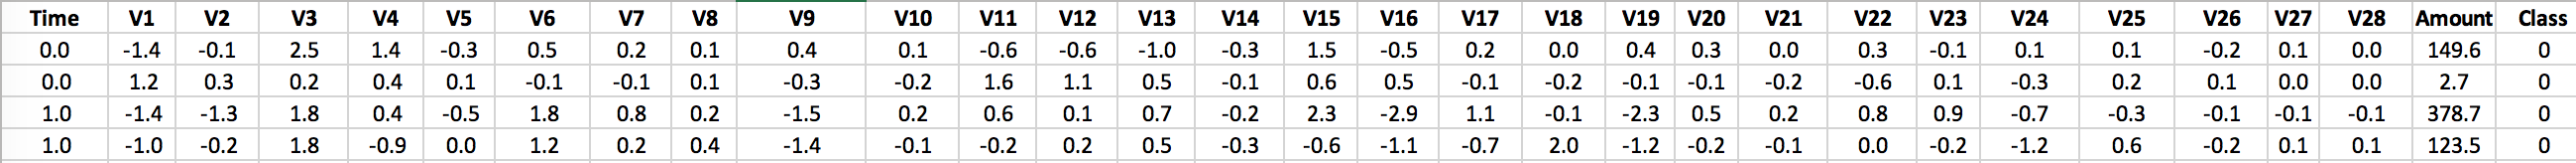

Download the data set from [here](https://www.dropbox.com/s/6z5jxcqaqipxiun/Project%202-Finance-Datasets.zip?dl=0 )

In [117]:
# import required libraries/modules
import pandas as pd
import numpy as np
import seaborn as sns
import base64, io, IPython

from PIL import Image as PILImage

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_recall_curve, classification_report, f1_score, accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score,train_test_split

from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as lines
plt.ioff()

In [2]:
# helper functions for this notebook
def display_image(path):
    img = PILImage.open(path)
    out = io.BytesIO()
    img.save(out, format='PNG')
    enc_str = base64.b64encode(out.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{enc_str}" />'
    return IPython.display.HTML(html)

#### Project Task: Week 1

#### Exploratory Data Analysis (EDA)

1. Perform an EDA on the Dataset.
   1. Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation
   2. Find if there is any connection between Time, Amount, and the transaction being fraudulent.
2. Check the class count for each class. It’s a class Imbalance problem.
3. Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.
   1. Oversampling or undersampling can be used to tackle the class imbalance problem
   2. Oversampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.
4. Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [144]:
# V colums
pca_vars = ['V%i' % k for k in range(1,29)]

In [145]:
# load train data
train_df = pd.read_csv('./Financial/train_data.csv')
test_df = pd.read_csv('./Financial/test_data_hidden.csv')

#### 1.0 Perform an EDA on the Dataset.


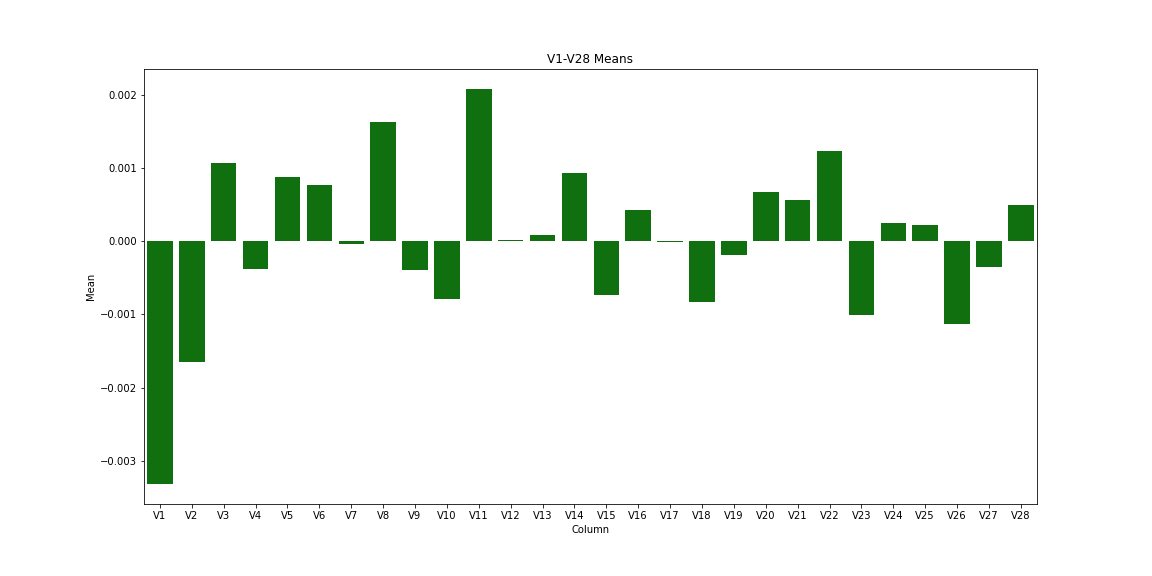

In [155]:
plt.figure(figsize=(16,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].mean(), color='green')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')
plt.savefig('./images/eda_v1_v28_means.png')
plt.close()

display_image('./images/eda_v1_v28_means.png')

##### Observation:
> All of V1-V28 have approximately zero mean.


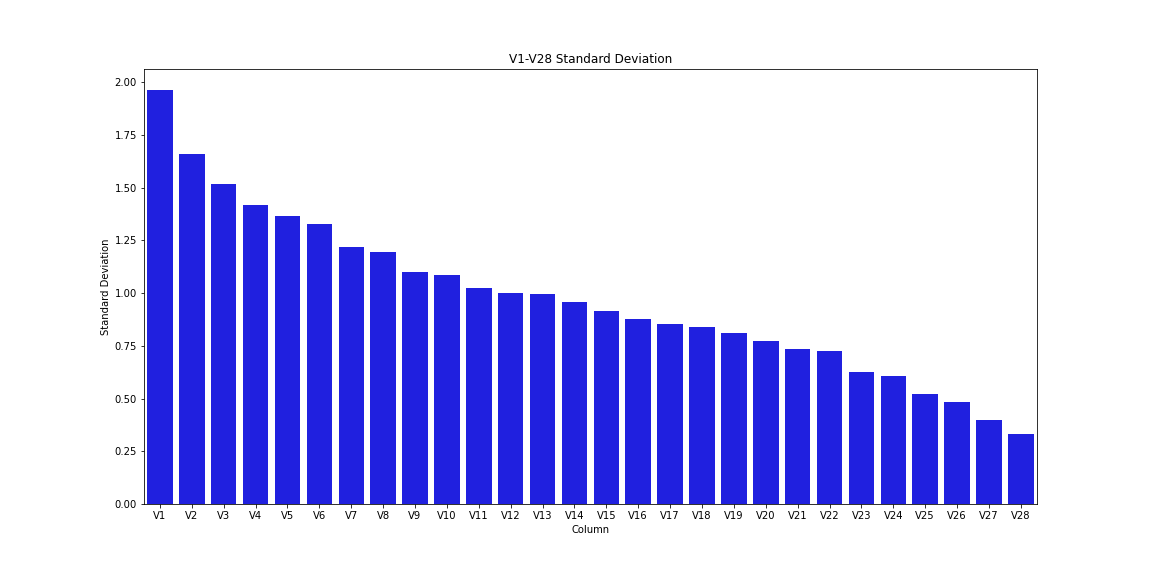

In [154]:
plt.figure(figsize=(16,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].std(), color='blue')
plt.xlabel('Column')
plt.ylabel('Standard Deviation')
plt.title('V1-V28 Standard Deviation')
plt.savefig('./images/eda_v1_v28_std.png')
plt.close()

display_image('./images/eda_v1_v28_std.png')

##### Observation:
> The PCA variables have unit variance, but as low as ~0.4 and as high as ~1.9


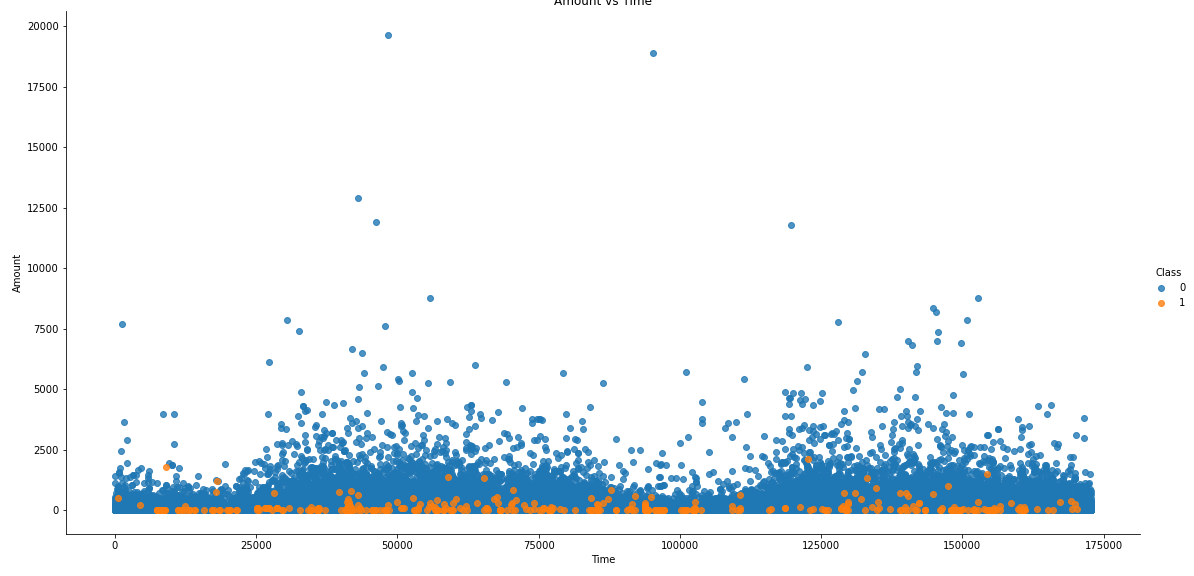

In [153]:
sns.lmplot('Time', 'Amount', train_df, hue='Class', fit_reg=False, height=8, aspect=16/8)
plt.title('Amount vs Time')
plt.savefig('./images/eda_time_amount_class.png')
plt.close()

display_image('./images/eda_time_amount_class.png')

##### Observation:
> 1. Doesn't seem like the time of transaction really matters.
> 2. Most of the fraud transactions are of low value

#### 2.0 Check the class count for each class. It’s a class Imbalance problem.

No Frauds 99.83 % of the dataset, count( 227451 )
Frauds 0.17 % of the dataset, count( 394 )



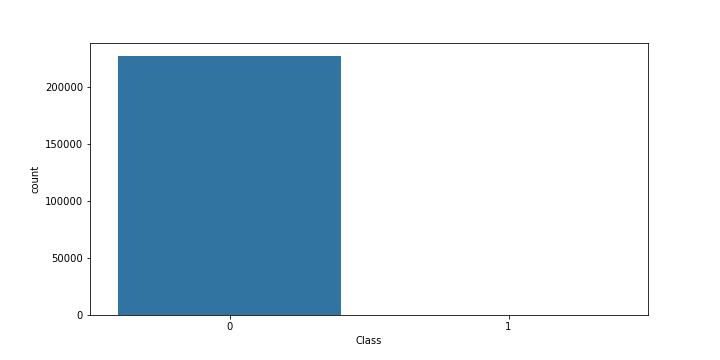

In [156]:
def plot_class_balance(df, name):
    vc = df['Class'].value_counts()
    print('No Frauds', round(vc[0]/len(df) * 100,2), '% of the dataset, count(', vc[0], ')')
    print('Frauds', round(vc[1]/len(df) * 100,2), '% of the dataset, count(', vc[1], ')')
    sns.countplot(x="Class", data=df) 
    plt.savefig(f'./images/{name}.png')
    plt.close()
    
plt.figure(figsize=(10,5))
plot_class_balance(train_df, 'class_balance1')
display_image(f'./images/class_balance1.png')

##### Observation:
> Clearly the data is totally unbalanced!!

#### 3.0 Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM

In [157]:
X = train_df.iloc[:, train_df.columns != 'Class']
y = train_df.iloc[:, train_df.columns == 'Class']

In [158]:
def getSamplingF1Score(name, steps):
    # A traditional scikit-learn Pipeline cannot be used; instead, 
    # Pipeline from the imbalanced-learn library can be used
    pl = imPipeline(steps=steps)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(pl, X, y, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'{name} F1 Score: {score}')

In [159]:
# trying simple over sampling and under sampling
over = RandomOverSampler()
under = RandomUnderSampler()

getSamplingF1Score('GaussianNB :: Over-Sampling', [
    ('o', over), 
    ('model', GaussianNB())
])
getSamplingF1Score('GaussianNB :: Under-Sampling', [
    ('u', under), 
    ('model', GaussianNB())
])

GaussianNB :: Over-Sampling F1 Score: 0.20286684506974195
GaussianNB :: Under-Sampling F1 Score: 0.1937035580880137


Over-sampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.

And also we can see Under-Sampling has a very low F1 score.

##### SMOTE Technique (Over-Sampling):
SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

In [160]:
smote = SMOTE(sampling_strategy='minority')

getSamplingF1Score('GaussianNB :: SMOTE-Sampling', [
    ('s', smote), 
    ('model', GaussianNB())
])

GaussianNB :: SMOTE-Sampling F1 Score: 0.2557906108026434


No Frauds 50.0 % of the dataset, count( 227451 )
Frauds 50.0 % of the dataset, count( 227451 )



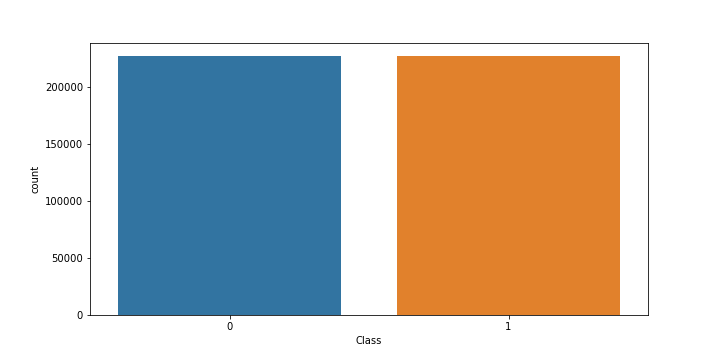

In [161]:
# finally smote the data
X_train_new, y_train_new = smote.fit_sample(X, y)
new_df = X_train_new.copy()
new_df['Class'] = y_train_new

plt.figure(figsize=(10,5))
plot_class_balance(new_df, 'class_balance2')
display_image(f'./images/class_balance2.png')

In [112]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454902 entries, 0 to 454901
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    454902 non-null  float64
 1   V1      454902 non-null  float64
 2   V2      454902 non-null  float64
 3   V3      454902 non-null  float64
 4   V4      454902 non-null  float64
 5   V5      454902 non-null  float64
 6   V6      454902 non-null  float64
 7   V7      454902 non-null  float64
 8   V8      454902 non-null  float64
 9   V9      454902 non-null  float64
 10  V10     454902 non-null  float64
 11  V11     454902 non-null  float64
 12  V12     454902 non-null  float64
 13  V13     454902 non-null  float64
 14  V14     454902 non-null  float64
 15  V15     454902 non-null  float64
 16  V16     454902 non-null  float64
 17  V17     454902 non-null  float64
 18  V18     454902 non-null  float64
 19  V19     454902 non-null  float64
 20  V20     454902 non-null  float64
 21  V21     45

#### 4.0 Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [162]:
# since Time realy does not matter, lets drop the column now
new_df.drop(['Time'], inplace=True, axis=1)
test_df.drop(['Time'], inplace=True, axis=1)

# Amount is not scaled, so lets scale that colums
new_df['Amount'] = StandardScaler().fit_transform(new_df['Amount'].values.reshape(-1, 1))
test_df['Amount'] = StandardScaler().fit_transform(test_df['Amount'].values.reshape(-1, 1))

In [258]:
def plot_cf(y_test, y_pred, name):
    cm_nn=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap='winter', cbar = False)
    plt.xlabel("Predicted Label", size = 18)
    plt.ylabel("True Label", size = 18)
    plt.title(f"{name} - Confusion Matrix", size = 20)
    plt.savefig(f'./images/{name}.png')
    plt.close()

def print_f1(y_test, y_pred):
    score = f1_score(y_test, y_pred)
    print(f'F1 Score: {score}')
    
def print_precision(y_test, y_pred):
    score = precision_score(y_test, y_pred)
    print(f'Precision Score: {score}')
    
def print_recall(y_test, y_pred):
    score = recall_score(y_test, y_pred)
    print(f'Recall Score: {score}')

def print_cf_f1(cls, X_test, y_test):
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(cls, X_test, y_test, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'Cross Validation F1 Score: {score}')

In [259]:
X_train = new_df.iloc[:, new_df.columns != 'Class']
y_train = new_df.iloc[:, new_df.columns == 'Class']

X_test = test_df.iloc[:, test_df.columns != 'Class']
y_test = test_df.iloc[:, test_df.columns == 'Class']

In [260]:
# F1-Score for Naïve Bayes (GaussianNB)
cls_nb = GaussianNB()
cls_nb.fit(X_train, y_train)

y_pred = cls_nb.predict(X_test)
plot_cf(y_test, y_pred, 'GaussianNB')

print_f1(y_test, y_pred)
print_cf_f1(cls_nb, X_test, y_test)

F1 Score: 0.10666666666666666
Cross Validation F1 Score: 0.120777357956075



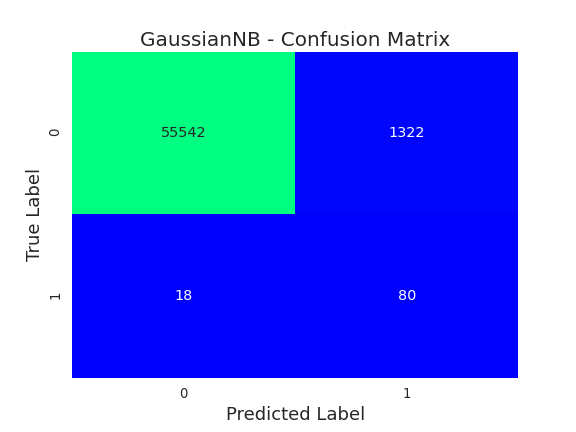

In [261]:
display_image('./images/GaussianNB.png')

In [262]:
# F1-Score for Logistic Regression (LogisticRegression)
cls_lr = LogisticRegression()
cls_lr.fit(X_train, y_train)

y_pred = cls_lr.predict(X_test)
plot_cf(y_test, y_pred, 'LogisticRegression')

print_f1(y_test, y_pred)
print_cf_f1(cls_lr, X_test, y_test)

F1 Score: 0.2037914691943128
Cross Validation F1 Score: 0.6652847805788982



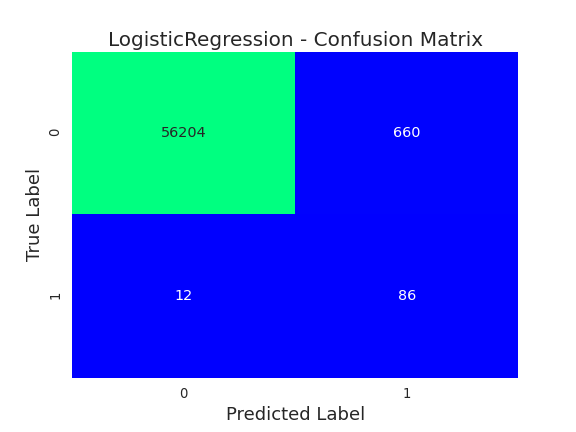

In [263]:
display_image('./images/LogisticRegression.png')

#### Project Task: Week 2

Modeling Techniques:

Try out models like Naive Bayes, Logistic Regression or SVM. Find out which one performs the best
Use different Tree-based classifiers like Random Forest and XGBoost. 
  1. Remember Tree-based classifiers work on two ideologies: Bagging or Boosting
  2. Tree-based classifiers have fine-tuning parameters which takes care of the imbalanced class. Random-Forest and XGBboost.

Compare the results of 1 with 2 and check if there is any incremental gain.

In [23]:
# F1-Score for RandomForestClassifier (RandomForestClassifier)
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier())
])
param_grid_rf = {
    'model__n_estimators': [10, 50, 150],
    'model__max_depth': [5, 25, None],
    'model__min_samples_leaf': [2, 4, 6],
    'model__min_samples_split': [5, 7, 10]
}

grid_rf = GridSearchCV(
    estimator=pipeline_rf, 
    param_grid=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)

grid_rf.fit(X_train, y_train)

y_pred = grid_rf.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'RandomForestClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_rf.best_estimator_, X_test, y_test)

print("\nBest Param", grid_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 89.3min finished


F1 Score: 0.837696335078534
Cross Validation F1 Score: 0.7523718610251118

Best Param {'model__max_depth': 25, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 150}



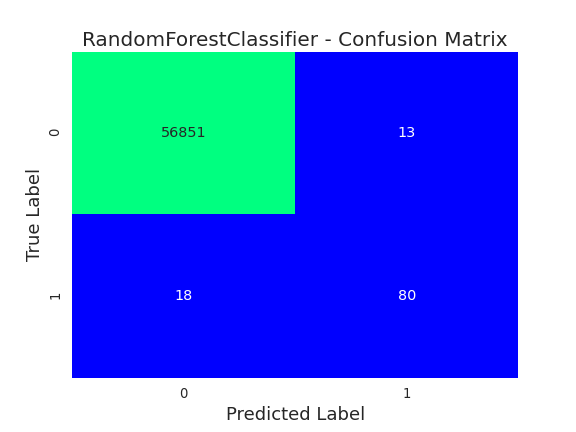

In [24]:
display_image('./images/RandomForestClassifier.png')

In [24]:
## F1-Score for XGBClassifier (XGBClassifier)
pipeline_xgb = Pipeline([
    ('model', XGBClassifier(objective='binary:logistic'))
])
param_grid_xgb = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__n_estimators': [50, 100, 200],
    'model__subsample': [0.3, 0.5, 0.9],
    'model__max_depth': [3, 6, 9]
}

grid_xgb = GridSearchCV(
    estimator=pipeline_xgb, 
    param_grid=param_grid_xgb, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)
grid_xgb.fit(X_train, y_train)

y_pred = grid_xgb.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'XGBClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_xgb.best_estimator_, X_test, y_test)

print("\nBest Param", grid_xgb.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 118.2min finished


F1 Score: 0.8102564102564104
Cross Validation F1 Score: 0.8049406604747162

Best Param {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.9}



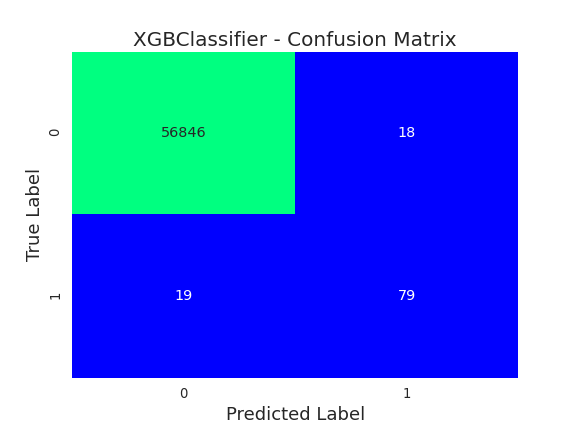

In [197]:
display_image(f'./images/XGBClassifier.png')

##### Observation:
> XGBClassifier we have highest cross validation f1 score

#### Project Task: Week 3

Applying ANN:

1. Use ANN (Artificial Neural Network) to identify fradulent and non-fradulent.
   1. Fine-tune number of layers
   2. Number of Neurons in each layers
   3. Experiment in batch-size
   4. Experiment with number of epochs. Check the observations in loss and accuracy
   5. Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
   6. Find out which activation performs best for this use case and why?
   7. Check Confusion Matrix, Precision, Recall and F1-Score
2. Try out Dropout for ANN. How is it performed? Compare model performance with the traditional ML based prediction models from above. 
3. Find the best setting of neural net that can be best classified as fraudulent and non-fraudulent transactions. Use techniques like Grid Search, Cross-Validation and Random search.

Anomaly Detection:

4. Implement anomaly detection algorithms.
   1. Assume that the data is coming from a single or a combination of multivariate Gaussian
   2. Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in 1.

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
print(tf.__version__)

2.2.0


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [267]:
INPUT_DIM = X_train.shape[1]

In [25]:
def generate_model(optimizer='Adam', 
                   kernel_initializer='glorot_uniform', 
                   activation='relu',
                   dropout_rate=0.5,
                   learning_rate=0.001):
    _model = Sequential()
    _model.add(Dense(32,input_dim = INPUT_DIM, activation = activation))

    _model.add(Dense(64, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(128, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))
    
    _model.add(Dense(16, activation = activation, kernel_initializer=kernel_initializer))
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(1, activation = 'sigmoid'))
    
    if(optimizer=='Adam'):
        optimizer = Adam(learning_rate=learning_rate)
    
    if(optimizer=='SGD'):
        optimizer = SGD(learning_rate=learning_rate, momentum=0.8)
                   
    if(optimizer=='RMSprop'):
        optimizer = RMSprop(learning_rate=learning_rate)
        
    _model.compile(optimizer = optimizer, loss = 'binary_crossentropy')
    
    return _model

In [234]:
model_sgd = generate_model(optimizer='SGD')

history_sgd = model_sgd.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history

In [235]:
model_adam = generate_model(optimizer='Adam')

history_adam = model_adam.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history


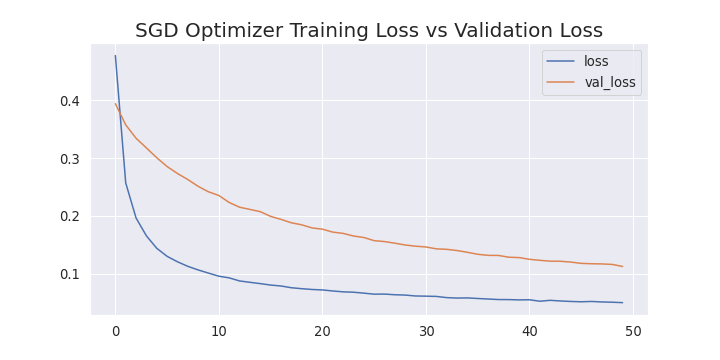

In [236]:
evaluation_metrics=pd.DataFrame(history_sgd)
evaluation_metrics.plot(figsize=(10,5))
plt.title("SGD Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/sgd.png')
plt.close()

display_image('./images/sgd.png')


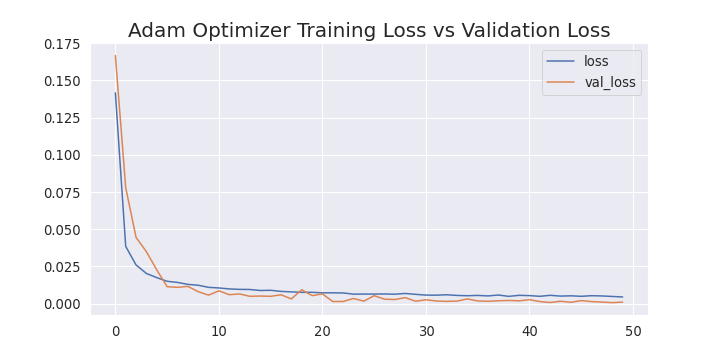

In [237]:
evaluation_metrics=pd.DataFrame(history_adam)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Adam Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/adam.png')
plt.close()

display_image('./images/adam.png')

In [238]:
y_pred = model_adam.predict_classes(X_test)

In [239]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

F1 Score: 0.6968325791855203
Precision Score: 0.6260162601626016
Recall Score: 0.7857142857142857



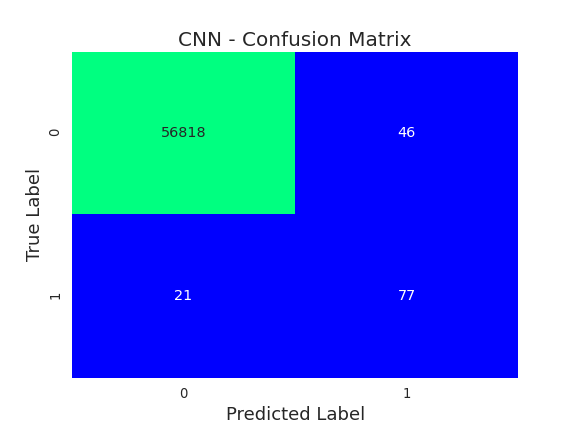

In [240]:
plot_cf(y_test, y_pred, 'CNN')
display_image('./images/CNN.png')

##### Observation:
> If we compare this with the XGBoost or RandomForest model, the little problem here is that, it is doing good prediction for the majority class, which is 0 or "No Fraud" cases, but for minority class, which is 1 or "Fraud" cases, it is performing a little less. There are more number of legitimate transactions that is predicted as a fraud. But I guess with a little more hyperparamters tuning, the model will be able to perform better than the XGBoost or RandomForest even for minority class.

In [104]:
model_ann = KerasClassifier(build_fn=generate_model, verbose=0)

param_grid_ann = dict(epochs=[50, 100], 
                      batch_size=[500, 1000], 
                      optimizer=['Adam', 'SGD'], 
                      kernel_initializer=['glorot_uniform', 'uniform'], 
                      activation=['relu', 'tanh'], 
                      learning_rate=[0.0001, 0.001], 
                      dropout_rate=[0.0, 0.2, 0.5]
                     )

grid_ann = GridSearchCV(
    estimator=model_ann, 
    param_grid=param_grid_ann, 
    scoring='f1', 
    n_jobs=1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=0, 
    return_train_score=False
)
grid_ann.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3d82d36f10>,
             n_jobs=1,
             param_grid={'activation': ['relu'], 'batch_size': [1000],
                         'dropout_rate': [0.2], 'epochs': [100],
                         'kernel_initializer': ['glorot_uniform'],
                         'learning_rate': [0.001], 'optimizer': ['Adam']},
             scoring='f1')

In [105]:
y_pred = grid_ann.best_estimator_.predict(X_test)
print("\nBest Param", grid_ann.best_params_)


Best Param {'activation': 'relu', 'batch_size': 1000, 'dropout_rate': 0.2, 'epochs': 100, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 0.001, 'optimizer': 'Adam'}



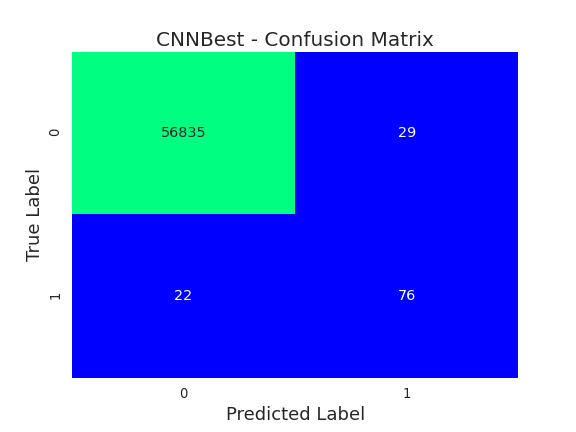

In [106]:
plot_cf(y_test, y_pred, 'CNNBest')
display_image('./images/CNNBest.png')

In [107]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

F1 Score: 0.7487684729064038
Precision Score: 0.7238095238095238
Recall Score: 0.7755102040816326


#### Anomaly Detection:

Implement anomaly detection algorithms.
1. Assume that the data is coming from a single or a combination of multivariate Gaussian
2. Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in 1

In [6]:
train_df = pd.read_csv('./Financial/train_data.csv')

In [7]:
from mpl_toolkits.mplot3d import Axes3D
def show_pca_df(df, name):
    X = df[df.columns[1:30]].to_numpy()
    y = df[df.columns[30]].to_numpy()

    X = MinMaxScaler().fit_transform(X)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(X)
    print(pca.explained_variance_ratio_)

    pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
    pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

    ax = Axes3D(plt.figure(figsize=(8, 8)))
    ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=50)
    ax.set_xlabel("pc_1")
    ax.set_ylabel("pc_2")
    ax.set_zlabel("pc_3")
    
    ax.w_xaxis.set_pane_color((0.4, 0.4, 0.4, 1.0))
    ax.w_yaxis.set_pane_color((0.7, 0.7, 0.7, 1.0))
    ax.w_zaxis.set_pane_color((0.6, 0.6, 0.6, 1.0))
    
    plt.savefig(f'./images/{name}.png')
    plt.close()

We are going to do a smaller plot after decreasing our dimensions from 30 to 3 with Principal Component Analysis.

[0.1566158  0.13090977 0.12976635]



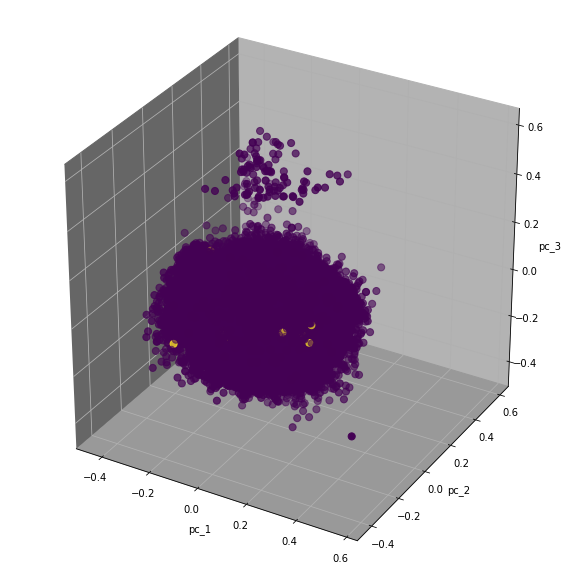

In [8]:
show_pca_df(train_df, 'pca_test')
display_image('./images/pca_test.png')

##### Observation:
> Our first reaction could be that there are two clusters and this would be an easy task but fraud data is yellow points! There are three visible yellow points in the large cluster. So let’s subsample the normal data while keeping the number of fraud data.

[0.21606385 0.15366356 0.08407197]



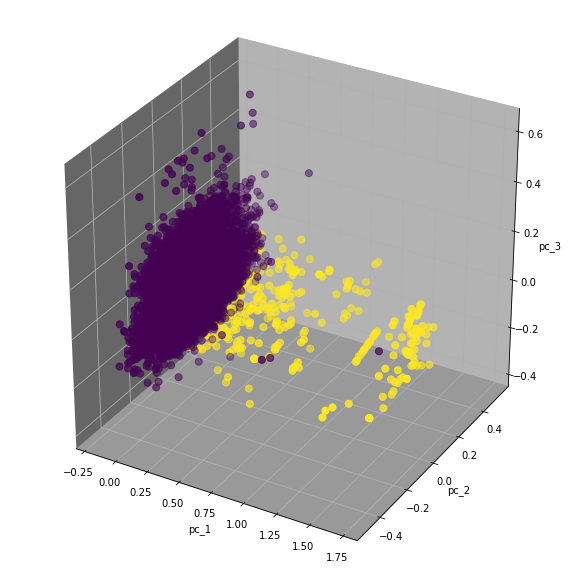

In [9]:
df_anomaly = train_df[train_df[train_df.columns[30]] > 0]
df_normal = train_df[train_df[train_df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
new_df = pd.concat([ df_anomaly, df_normal])

show_pca_df(new_df, 'pca_3')
display_image('./images/pca_3.png')

##### Observation:
> Now it is visible that normal transactions are clustered in a disk while frauded transactions are more distributed.

> We are going to build an autoencoder.

#### Creating The Model
Autoencoder has symmetric encoding and decoding layers that are "dense". We are reducing the input into some form of simplified encoding and then expanding it again. The input and output dimension is the feature space (e.g. 30 columns), so the encoding layer should be smaller by an amount that expect to represent some feature. In this case, I am encoding 30 columns into 14 dimensions so I am expecting high-level features to be represented by roughly two columns (30/14 = 2.1). Of those high-level features, I am expecting them to map to roughly seven hidden/latent features in the data.

Additionally, the epochs, batch size, learning rate, learning policy, and activation functions were all set to values empirically good values.

In [11]:
# start with fresh data
train_df = pd.read_csv('./Financial/train_data.csv')
test_df = pd.read_csv('./Financial/test_data_hidden.csv')

X_train = train_df.iloc[:, train_df.columns != 'Class']
y_train = train_df.iloc[:, train_df.columns == 'Class']
X_test = test_df.iloc[:, test_df.columns != 'Class']
y_test = test_df.iloc[:, test_df.columns == 'Class']

print(X_train.shape)

print(X_test.shape)
print(y_test.shape)

(227845, 30)
(56962, 30)
(56962, 1)


In [12]:
scaler = StandardScaler().fit(X_train.Amount.values.reshape(-1,1))
X_train['Amount'] = scaler.transform(X_train.Amount.values.reshape(-1,1))
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

X_train['Time'] = scaler.transform(X_train.Amount.values.reshape(-1,1))
X_test['Time'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

In [13]:
X_train.shape

(227845, 30)

In [20]:
nb_epoch = 50
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 18
hidden_dim1 = 10 #int(encoding_dim / 2) #i.e. 7
hidden_dim2 = 6
learning_rate = 1e-7

In [21]:
# This returns a tensor
input_layer = Input(shape=(input_dim, ))

In [22]:
# a layer instance is callable on a tensor, and returns a tensor
# Dense implements the operation: output = activation(dot(input, kernel) + bias), where
# activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and 
# bias is a bias vector created by the layer (only applicable if use_bias is True).

# activity_regularizer: Regularizer function applied to the output of the layer
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="elu")(encoder)
encoder = Dense(hidden_dim2, activation="tanh")(encoder)
decoder = Dense(hidden_dim2, activation='elu')(encoder)
decoder = Dense(hidden_dim1, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='elu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

In [23]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.7755 - accuracy: 0.5216 - val_loss: 0.6950 - val_accuracy: 0.6036
Epoch 2/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.6535 - accuracy: 0.6239 - val_loss: 0.6439 - val_accuracy: 0.6365
Epoch 3/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.6173 - accuracy: 0.6502 - val_loss: 0.6201 - val_accuracy: 0.6559
Epoch 4/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.6006 - accuracy: 0.6595 - val_loss: 0.6082 - val_accuracy: 0.6575
Epoch 5/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.5916 - accuracy: 0.6636 - val_loss: 0.6008 - val_accuracy: 0.6537
Epoch 6/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.5851 - accuracy: 0.6630 - val_loss: 0.5975 - val_accuracy: 0.6580
Epoch 7/50
1781/1781 [==============================] - 4s 2ms/step - loss: 0.5804 - accuracy: 0.6647 - val_loss: 0.5906 - val_accuracy:

#### Model Evaluation

#### Model Loss
The loss of our current model seems to be converging and so more training epochs are not likely going to help. Let's explore this visually to confirm.

In [72]:
plt.figure(figsize = (10,5))
plt.plot(history['loss'], linewidth=2, label = 'Training Loss')
plt.plot(history['val_loss'], linewidth=2, label = 'Test Loss')
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('./images/autoencoder_val_loss.png')
plt.close()


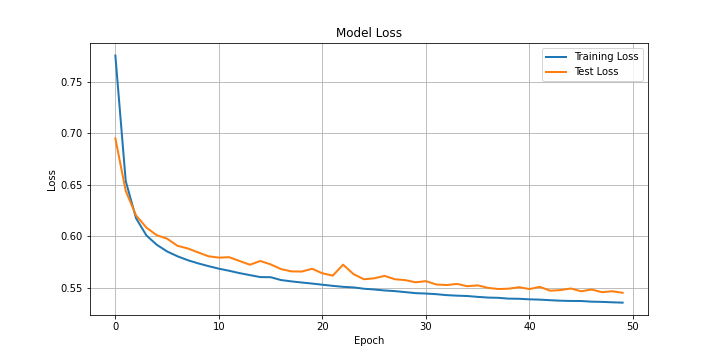

In [73]:
display_image('./images/autoencoder_val_loss.png')

#### Reconstruction Error Check
Autoencoders are trained to reduce reconstruction error which we show below:

In [32]:
X_test_predictions = autoencoder.predict(X_test)
X_test_predictions.shape

(56962, 30)

In [34]:
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)

In [37]:
error_df = y_test.copy()
error_df['Reconstruction_error'] = mse
error_df = error_df.rename(columns={'Class': 'True_class'})
error_df.describe()

,True_class,Reconstruction_error
count,56962.000000,56962.000000
mean,0.001720,0.544883
std,0.041443,6.925371
min,0.000000,0.022342
25%,0.000000,0.133674
50%,0.000000,0.218913
75%,0.000000,0.399207
max,1.000000,1521.776661


#### ROC Curve Check
Receiver operating characteristic curves are an expected output of most binary classifiers. Since we have an imbalanced data set they are somewhat less useful. Why? Because you can generate a pretty good-looking curve by just simply guessing everything is the normal case because there are so proportionally few cases of fraud.

In [99]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize = (10,8))
plt.plot(false_pos_rate, true_pos_rate, label='AUC = %0.3f'% roc_auc, linewidth=2)
plt.plot([0,1],[0,1], linewidth=2)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.savefig('./images/autoencoder_auc_roc.png')
plt.close()


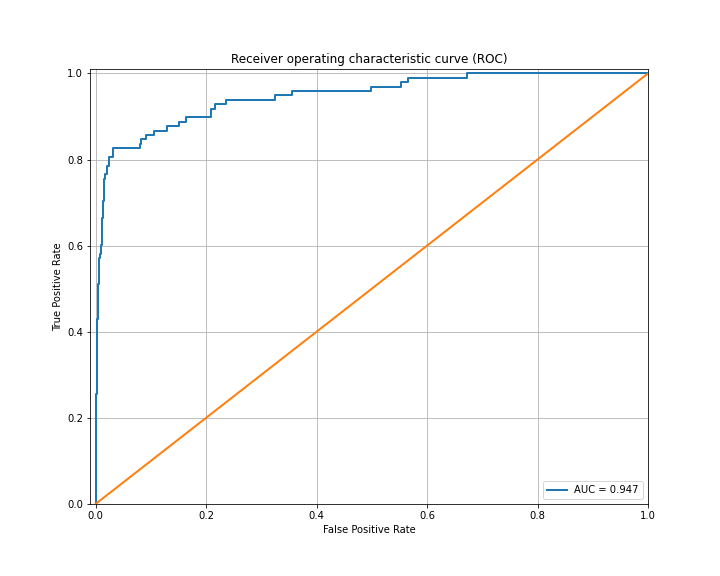

In [100]:
display_image('./images/autoencoder_auc_roc.png')

#### Recall vs. Precision Thresholding
Now let's look at recall vs. precision to see the trade-off between the two.

In [97]:
# calculates precision/recall using reconstruction error as the decision function
# returns: 
# precision_rt: Precision values such that element i is the precision of predictions with 
#               score >= thresholds[i] and the last element is 1.
# recall_rt: Decreasing recall values such that element i is the recall of predictions with 
#           score >= thresholds[i] and the last element is 0.
# threshold_rt = Increasing thresholds on the decision function used to compute
#                precision and recall.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class,
                                                               error_df.Reconstruction_error)

pr_auc = auc(recall_rt, precision_rt,)

plt.figure(figsize=(10, 6))
plt.plot(recall_rt, precision_rt, label='AUC = %0.3f'% pr_auc, linewidth=2)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.savefig('./images/autoencoder_rec_prec.png')
plt.close()


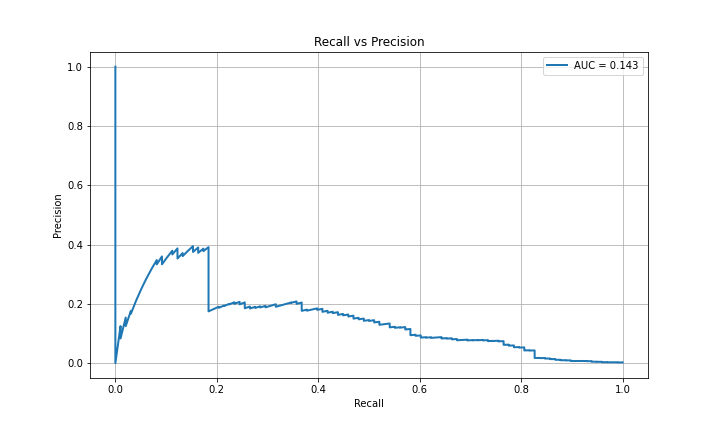

In [98]:
display_image('./images/autoencoder_rec_prec.png')

Precision and recall are the eternal tradeoff in data science, so at some point you have to draw an arbitrary line, or a threshold. Where this line will be drawn is essentially a business decision. In this case, you are trading off the cost between missing a fraudulent transaction and the cost of falsely flagging the transaction as a fraudulent even when it is not.

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()
plt.savefig('./images/autoencoder_rec_prec_thres.png')
plt.close()


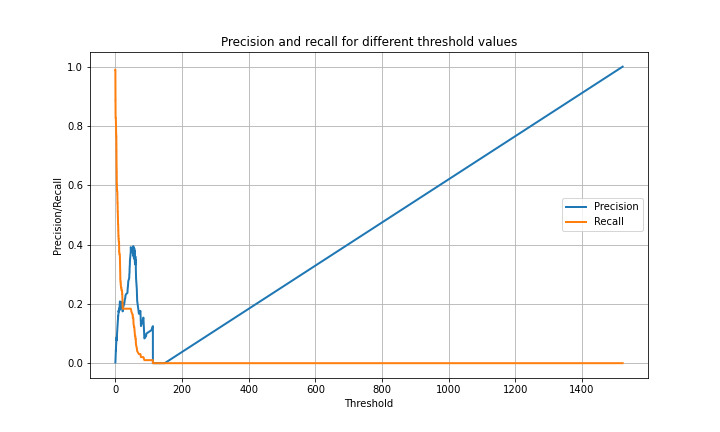

In [96]:
display_image('./images/autoencoder_rec_prec_thres.png')

#### Project Task: Week 4
Inference and Observations:

Visualize the scores for Fraudulent and Non-Fraudulent transactions. Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system. Can this score be used as an engineered feature in the models developed previously? Are there any incremental gains in F1-Score? Why or Why not? Be as creative as possible in finding other interesting insights.

#### Reconstruction Error vs Threshold Check

In [107]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize = (10,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error for different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data point index")
plt.grid()
plt.savefig('./images/autoencoder_threshold.png')
plt.close();


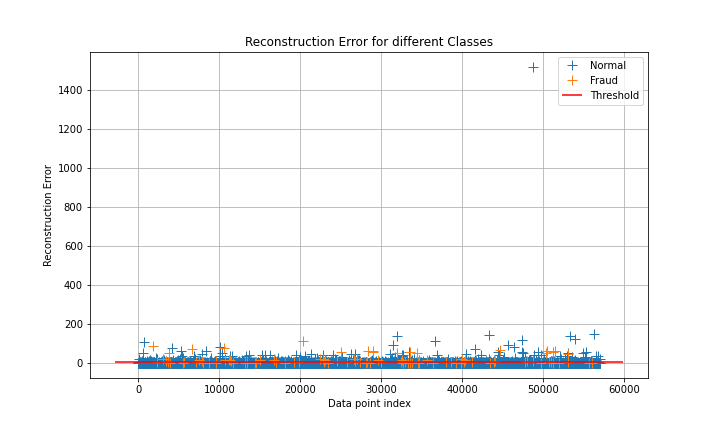

In [108]:
display_image('./images/autoencoder_threshold.png')

#### Confusion Matrix
Finally, we take a look at a traditional confusion matrix for the 20% of the data we randomly held back in the testing set. Here I really take a look at the ratio of detected fraud cases to false positives. A 1:10 ratio is a fairly standard benchmark if there are no business rules or cost tradeoffs that dominate that decision.

In [114]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
LABELS = ["Normal","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('./images/autoencoder_conf_matrix.png')
plt.close()


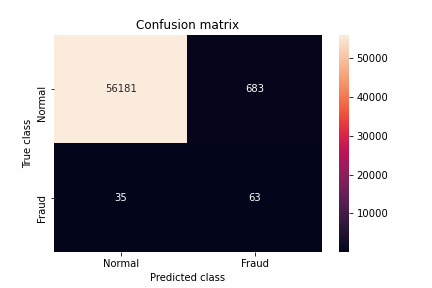

In [115]:
display_image('./images/autoencoder_conf_matrix.png')

In [119]:
## Chosen metric is AUC ROC as data is imbalanced
print("Area under ROC : ", roc_auc_score(error_df.True_class,pred_y ))

Area under ROC :  0.815423014309832


In [121]:
print(classification_report(error_df.True_class,pred_y))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.08      0.64      0.15        98

    accuracy                           0.99     56962
   macro avg       0.54      0.82      0.57     56962
weighted avg       1.00      0.99      0.99     56962



In [129]:
threshold_fixed = 7
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
matrix = confusion_matrix(error_df.True_class, pred_y)

In [130]:
tpos = matrix[0][0]
fneg = matrix[1][1]
fpos = matrix[0][1]
tneg = matrix[1][0]

In [131]:
print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
print("Sensitivity/Recall for Model : {}".format(round(recall_score(error_df.True_class, pred_y), 2)))
print("F1 Score for Model : {}".format(round(f1_score(error_df.True_class, pred_y), 2)))

Accuracy: 99.35%
Sensitivity/Recall for Model : 0.52
F1 Score for Model : 0.21
